[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/crossvalidation.ipynb)

# Test and CrossValidate

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

## Load data

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
# df = pd.read_csv(data_location + "air_passengers.csv")

# 1 Validation using in-built utils
## 1.1 Train Test Validation

In [3]:
m = NeuralProphet(seasonality_mode= "multiplicative", learning_rate = 0.1)

df = pd.read_csv(data_location + "air_passengers.csv")
df_train, df_val = m.split_df(df=df, freq="MS", valid_p=0.2)

metrics_train = m.fit(df=df_train, freq="MS")
metrics_val = m.test(df=df_val)

# metrics_train
metrics_val

,SmoothL1Loss,MAE,MSE
0,0.005664,27.872511,1145.584351


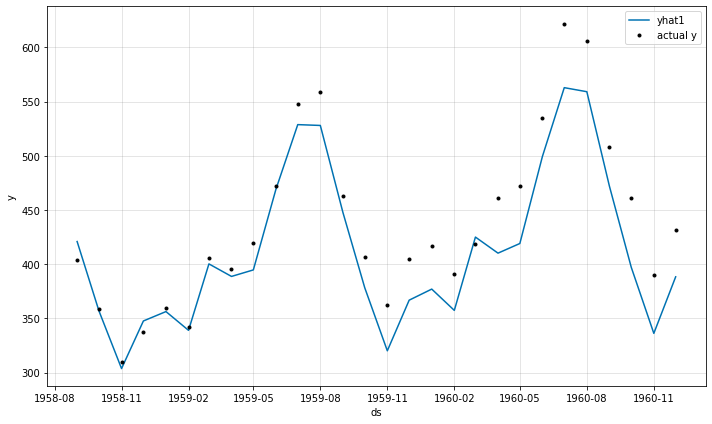

In [4]:
future = m.make_future_dataframe(df_train, periods=len(df_val))
forecast = m.predict(future)
forecast['y'] = df_val['y']
fig = m.plot(forecast)

In [7]:
future_dates = pd.date_range(start=last_date, periods=len(df_val) + 1, freq="MS")

## 1.2 CrossValidation

In [8]:
METRICS = ['SmoothL1Loss', 'MAE', 'MSE']
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

df = pd.read_csv(data_location + "air_passengers.csv")
folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="MS", k=5, fold_pct=0.1)

In [9]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_val = pd.DataFrame(columns=METRICS)

for df_train, df_val in folds:
    m = NeuralProphet(**params)
    train = m.fit(df=df_train, freq="MS")
    val = m.test(df=df_val)
    metrics_train = metrics_train.append(train[METRICS].iloc[-1])
    metrics_val = metrics_val.append(val[METRICS].iloc[-1])

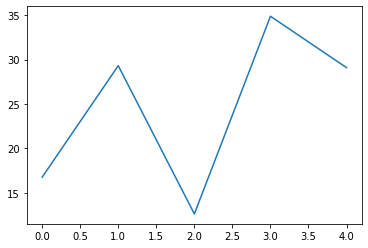

In [10]:
# metrics_train.reset_index(drop=True)
plt = metrics_val.reset_index(drop=True)["MAE"].plot()

In [11]:
metrics_val.describe().loc[["mean", "std", "min", "max"]]

,SmoothL1Loss,MAE,MSE
mean,0.004300,24.529597,815.740039
std,0.002511,9.388040,494.677571
min,0.001269,12.625933,256.610596
max,0.007951,34.869740,1518.343628


# 2 Using Benchmark Framework
Note: The Benchmarking Framework does currently not properly support auto-regression or lagged covariates with multiple step ahead forecasts.

In [12]:
from neuralprophet.benchmark import Dataset, NeuralProphetModel, SimpleExperiment, CrossValidationExperiment
from neuralprophet.benchmark import SimpleBenchmark, CrossValidationBenchmark

## 2.1 SimpleExperiment
Let's set up a train test experiment:

In [13]:
ts = Dataset(df = pd.read_csv(data_location + "air_passengers.csv"), name = "air_passengers", freq = "MS")
params = {"seasonality_mode": "multiplicative"}
exp = SimpleExperiment(
    model_class=NeuralProphetModel,
    params=params,
    data=ts,
    metrics=["MAE", "MSE"],
    test_percentage=25,
)
result_train, result_val = exp.fit()

  0%|          | 0/203 [00:00<?, ?it/s]

In [14]:
# result_train
result_val

{'data': 'air_passengers',
 'model': 'NeuralProphet',
 'params': "{'seasonality_mode': 'multiplicative'}",
 'MAE': 24.922279357910156,
 'MSE': 849.2064208984375}

## 2.2 CrossValidationExperiment
Let's crossvalidate:

In [15]:
ts = Dataset(df = pd.read_csv(data_location + "air_passengers.csv"), name = "air_passengers", freq = "MS")
params = {"seasonality_mode": "multiplicative"}
exp_cv = CrossValidationExperiment(
    model_class=NeuralProphetModel,
    params=params,
    data=ts,
    metrics=["MAE", "MSE"],
    test_percentage=10,
    num_folds=3,
    fold_overlap_pct=0,
  )
result_train, result_val = exp_cv.fit()

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

In [16]:
result_val

{'data': 'air_passengers',
 'model': 'NeuralProphet',
 'params': "{'seasonality_mode': 'multiplicative'}",
 'MAE': [16.954103469848633, 12.443696975708008, 32.47218704223633],
 'MSE': [451.8210754394531, 254.29800415039062, 1263.4945068359375]}